In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
from lime import lime_tabular
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('train-data.csv')

In [4]:
flagged_fraud_rows = df[df['isFlaggedFraud'] == 1]
flagged_fraud_rows
len(flagged_fraud_rows)

16

In [5]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,44,CASH_IN,39559.66,C1043949467,21210.00,60769.66,C1033211852,0.00,0.00,0,0
1,208,TRANSFER,49398.49,C905629380,0.00,0.00,C304353339,61410.21,110808.70,0,0
2,15,CASH_OUT,2496.77,C1366493715,0.00,0.00,C281656657,3387211.35,3389708.12,0,0
3,154,PAYMENT,12518.30,C977164605,0.00,0.00,M1623115253,0.00,0.00,0,0
4,19,PAYMENT,11768.12,C1486909690,22513.00,10744.88,M169776944,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
495,235,CASH_OUT,98585.66,C1981132549,10751.00,0.00,C1448947115,8999254.90,9097840.56,0,0
496,39,PAYMENT,1848.04,C985595178,119689.74,117841.70,M1981106442,0.00,0.00,0,0
497,280,PAYMENT,10626.18,C1317183299,0.00,0.00,M1008804855,0.00,0.00,0,0
498,592,CASH_OUT,342462.31,C1932081493,711672.00,369209.69,C173723544,311399.16,653861.46,0,0


In [6]:
df.columns.values

array(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud'], dtype=object)

In [7]:
df['amount_diff'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['dest_amount_diff'] = df['newbalanceDest'] - df['oldbalanceDest']
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

In [8]:
df.columns


Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'amount_diff', 'dest_amount_diff', 'type_encoded'],
      dtype='object')

In [9]:
if 'type' in df.columns:
    le = LabelEncoder()
    df['type_encoded'] = le.fit_transform(df['type'])
    print("Unique values in 'type':", df['type'].unique())
    print("Encoded values:", le.classes_)
else:
    print("'type' column not found in the dataset")

Unique values in 'type': ['CASH_IN' 'TRANSFER' 'CASH_OUT' 'PAYMENT' 'DEBIT']
Encoded values: ['CASH_IN' 'CASH_OUT' 'DEBIT' 'PAYMENT' 'TRANSFER']


In [10]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'amount_diff', 'dest_amount_diff', 'type_encoded'],
      dtype='object')

In [11]:
features = ['amount', 'type_encoded', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 
            'amount_diff', 'dest_amount_diff']
features

['amount',
 'type_encoded',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'amount_diff',
 'dest_amount_diff']

In [12]:
X, y = df[features], df['isFraud']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
def train_isolation_forest(X, contamination=0.01):
    model = IsolationForest(contamination=contamination, random_state=42)
    model.fit(X)
    return model

In [16]:
def train_random_forest(X, y):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model

In [17]:
def evaluate_model(model, X, y, model_type='isolation_forest'):
    if model_type == 'isolation_forest':
        predictions = model.predict(X)
        predictions = np.where(predictions == 1, 0, 1)
    else:
        predictions = model.predict(X)
    
    print(f"\nClassfication Report:\n{classification_report(y,predictions)}")
    print(f"\nConfusion Matrix:\n{confusion_matrix(y,predictions)}")
    print(f"\nAccuracy Score:\n{accuracy_score(y,predictions)}")
    print(f"\nF1 Score:\n{f1_score(y,predictions)}")
    print(f"\nPrecision Score:\n{precision_score(y,predictions)}")
    print(f"\nRecall Score:\n{recall_score(y,predictions)}")


In [18]:
def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)


In [19]:
def lime_explanation(model, X, feature_names):
    explainer = lime_tabular.LimeTabularExplainer(X, feature_names=feature_names, class_names=['Not Fraud', 'Fraud'], mode='classification')
    exp = explainer.explain_instance(X[0], model.predict_proba, num_features=10)
    exp.show_in_notebook()

In [20]:
def permutation_importance_analysis(model, X, y):
    # Print model performance before permutation
    y_pred = model.predict(X)
    print(f"Accuracy before permutation: {accuracy_score(y, y_pred):.4f}")
    print(f"F1 score before permutation: {f1_score(y, y_pred):.4f}")

    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='f1')
    sorted_idx = result.importances_mean.argsort()

    # Ensure X is a DataFrame to get feature names
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=features)

    feature_names = X.columns

    # Print the importance values
    for i in sorted_idx:
        print(f"{feature_names[i]}: {result.importances_mean[i]:.6f} +/- {result.importances_std[i]:.6f}")

    plt.figure(figsize=(10, 8))
    plt.barh(range(X.shape[1]), result.importances_mean[sorted_idx])
    plt.yticks(range(X.shape[1]), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Permutation Importance (F1 score)")
    plt.title("Permutation Importance of Features")
    plt.tight_layout()
    plt.show()

In [21]:
def correlation_matrix(df, target='isFraud'):
    # Select numeric columns and the target
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cols_to_use = [col for col in numeric_cols if col != target] + [target]
    
    # Calculate the correlation matrix
    corr_matrix = df[cols_to_use].corr()
    
    # Sort the correlations with the target variable
    target_correlations = corr_matrix[target].sort_values(ascending=False)
    
    # Plot the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Matrix (including {target})')
    plt.tight_layout()
    plt.show()
    
    # Print the correlations with the target variable
    print(f"\nCorrelations with {target}:")
    print(target_correlations)

In [22]:
def partial_dependence_plots(model, X):
    PartialDependenceDisplay.from_estimator(model, X, features)
    plt.show()

In [23]:
def feature_importance_plot(model, X):
    importances = model.feature_importances_
    forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

In [24]:
import os
import sys 
def replace_distutils():
    # Get the value of SETUPTOOLS_USE_DISTUTILS from the environment
    use_distutils = os.getenv('SETUPTOOLS_USE_DISTUTILS', 'local')
    
    # Check if the environment variable is either unset or set to 'local'
    if use_distutils == 'local':
        # Attempt to replace sys.modules['distutils'] with setuptools._distutils
        try:
            import setuptools._distutils  # Import setuptools._distutils
            
            # Replace the distutils module in sys.modules
            sys.modules['distutils'] = setuptools._distutils
            
            print("distutils has been replaced by setuptools._distutils")
        except ImportError:
            print("setuptools._distutils not found. Ensure setuptools is installed.")
    else:
        print(f"SETUPTOOLS_USE_DISTUTILS is set to {use_distutils}, no replacement made.")

# Example usage
replace_distutils()

distutils has been replaced by setuptools._distutils


In [25]:
from treeinterpreter import treeinterpreter as ti

def tree_interpreter_analysis(model, X, feature_names=None, num_samples=5):
    # Handle both DataFrame and NumPy array inputs
    if isinstance(X, np.ndarray):
        sample_indices = np.random.choice(X.shape[0], num_samples, replace=False)
        X_samples = X[sample_indices]
        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    else:
        sample_indices = np.random.choice(X.shape[0], num_samples, replace=False)
        X_samples = X.iloc[sample_indices]
        if feature_names is None:
            feature_names = X.columns
    
    # Get predictions and breakdowns
    prediction, bias, contributions = ti.predict(model, X_samples)
    
    # Plot the contributions for each sample
    for i, idx in enumerate(sample_indices):
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Contributions for Sample {idx}")
        plt.barh(feature_names, contributions[i][:, 1])  # contributions[:, 1] for positive class
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.xlabel("Contribution to prediction")
        plt.tight_layout()
        plt.show()
        
        print(f"Sample {idx}:")
        print(f"Prediction: {prediction[i][1]:.4f}")
        bias_value = bias[i] if isinstance(bias[i], (float, int)) else bias[i].mean()
        print(f"Bias (average model prediction): {bias_value:.4f}")
        print("Top 5 contributing features:")
        top_contributions = sorted(zip(feature_names, contributions[i][:, 1]), key=lambda x: abs(x[1]), reverse=True)[:5]
        for feature, contribution in top_contributions:
            print(f"  {feature}: {contribution:.4f}")
        print("\n")

In [26]:
isolation_forest = train_isolation_forest(X_train_scaled)
random_forest = train_random_forest(X_train_scaled, y_train)

In [155]:
print("Isolation Forest Evaluation:")
evaluate_model(isolation_forest, X_test_scaled, y_test, 'isolation_forest')
print("\nRandom Forest Evaluation:")
evaluate_model(random_forest, X_test_scaled, y_test, 'random_forest')

Isolation Forest Evaluation:

Classfication Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        96
           1       0.00      0.00      0.00         4

    accuracy                           0.96       100
   macro avg       0.48      0.50      0.49       100
weighted avg       0.92      0.96      0.94       100


Confusion Matrix:
[[96  0]
 [ 4  0]]

Accuracy Score:
0.96

F1 Score:
0.0

Precision Score:
0.0

Recall Score:
0.0

Random Forest Evaluation:

Classfication Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        96
           1       1.00      0.75      0.86         4

    accuracy                           0.99       100
   macro avg       0.99      0.88      0.93       100
weighted avg       0.99      0.99      0.99       100


Confusion Matrix:
[[96  0]
 [ 1  3]]

Accuracy Score:
0.99

F1 Score:
0.8571428571428571

Precision Score:
1.0

Recall Score:
0

C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [28]:
test_predictions = random_forest.predict(X_test_scaled)

results_df = X_test.copy()
results_df['isFraud'] = y_test
results_df['Pred_isFraud'] = test_predictions

results_df.to_csv('results_test.csv', index=False)

print("Results saved to 'results_test.csv'")

Results saved to 'results_test.csv'



SHAP Analysis for Random Forest:


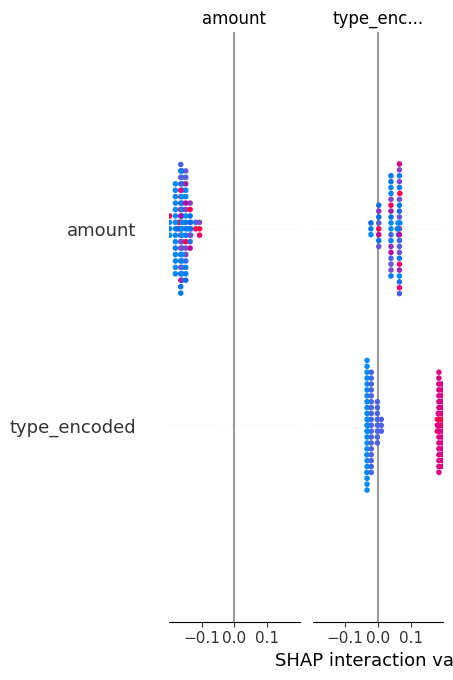

In [29]:
print("\nSHAP Analysis for Random Forest:")
shap_analysis(random_forest, X_test)


SHAP Analysis for Random Forest:


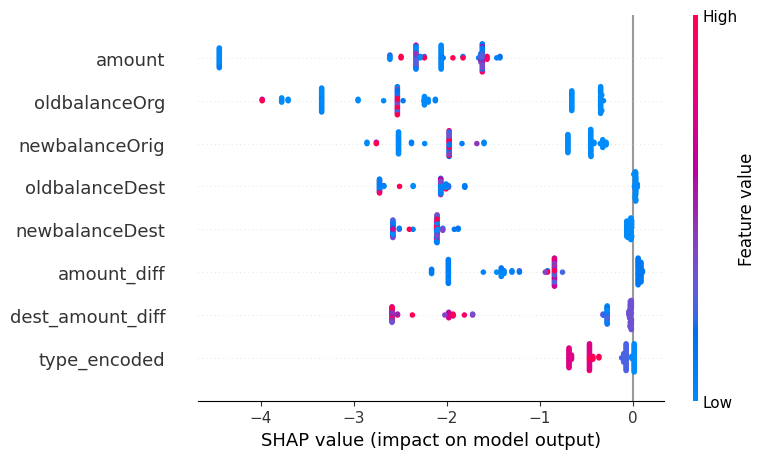

In [30]:
print("\nSHAP Analysis for Random Forest:")
shap_analysis(isolation_forest, X_test)

In [31]:
print("\nLIME Explanation for a single instance:")
lime_explanation(random_forest, X_test.values, X_test.columns)


LIME Explanation for a single instance:



Permutation Importance Analysis:
Accuracy before permutation: 0.8200
F1 score before permutation: 0.1818


C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Pytho

amount: 0.000000 +/- 0.000000
oldbalanceDest: 0.000000 +/- 0.000000
amount_diff: 0.010680 +/- 0.005802
newbalanceOrig: 0.012362 +/- 0.015173
dest_amount_diff: 0.027554 +/- 0.049216
oldbalanceOrg: 0.059782 +/- 0.003210
type_encoded: 0.084220 +/- 0.107905
newbalanceDest: 0.088827 +/- 0.121026


C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Pytho

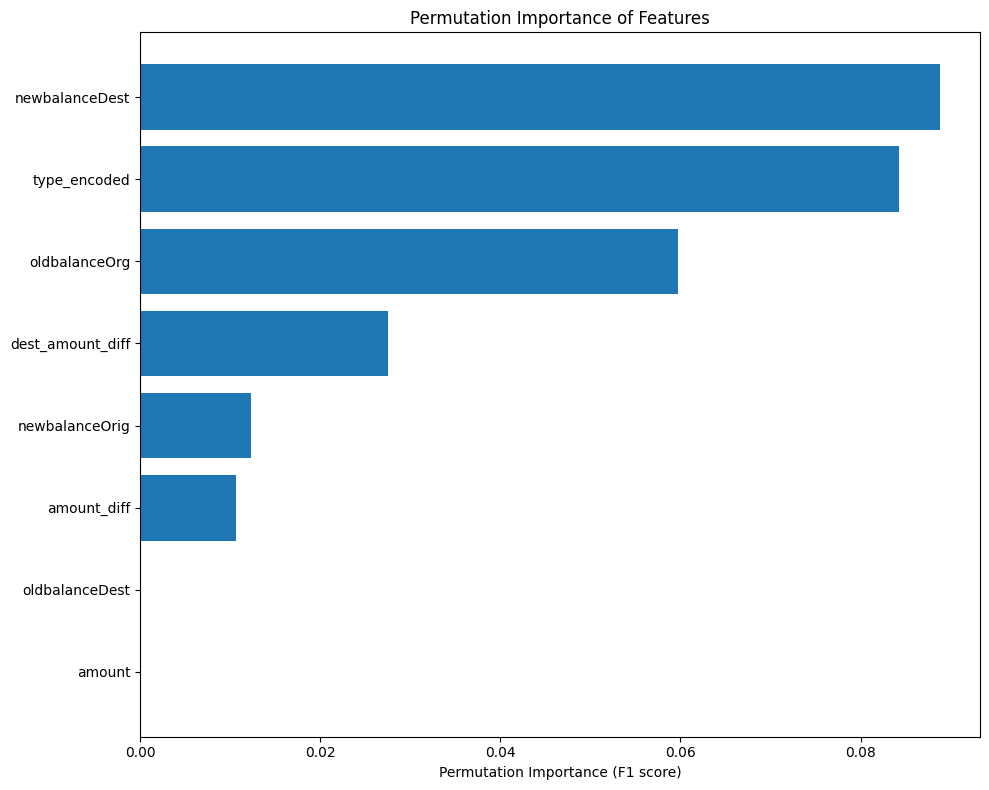

In [32]:
print("\nPermutation Importance Analysis:")
permutation_importance_analysis(random_forest, X_test, y_test)

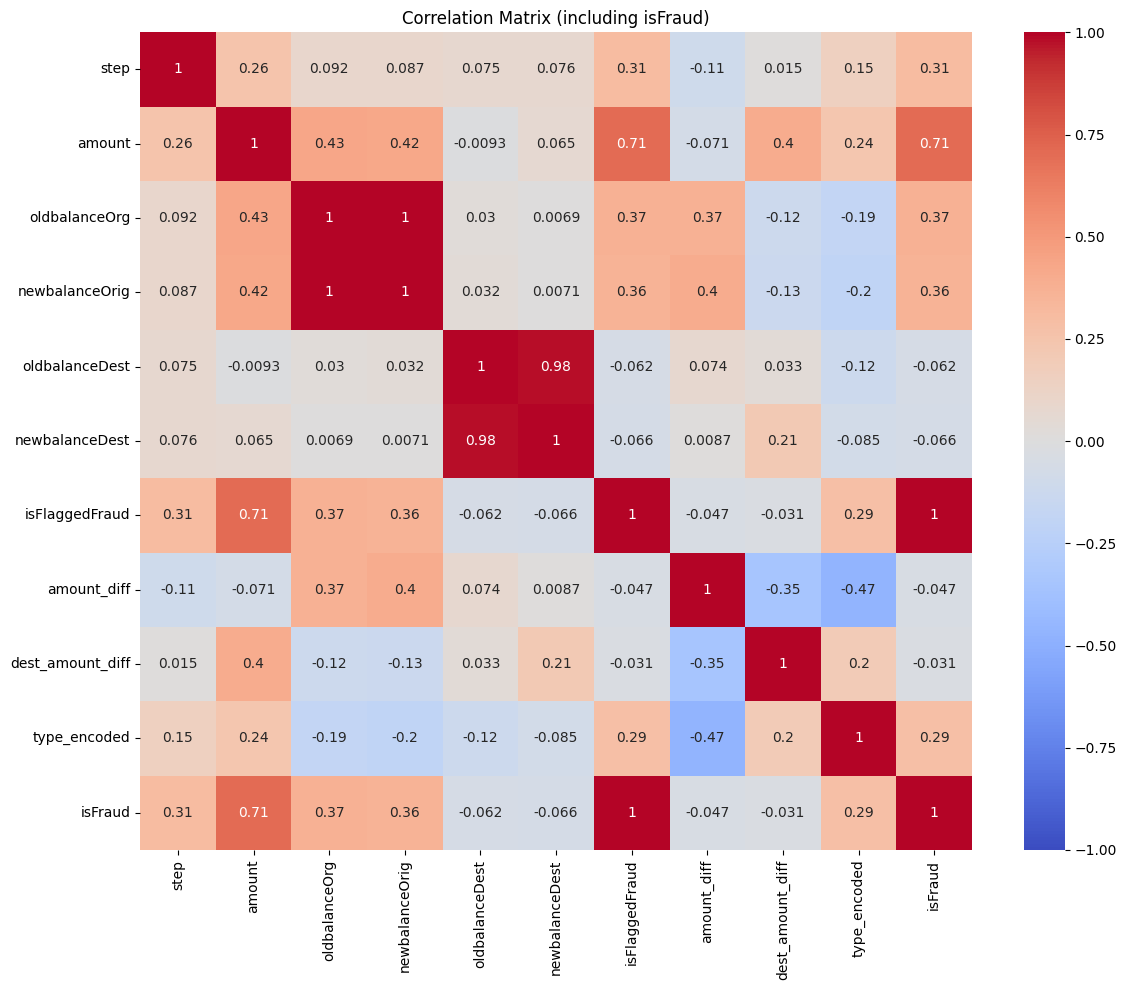


Correlations with isFraud:
isFlaggedFraud      1.000000
isFraud             1.000000
amount              0.707422
oldbalanceOrg       0.368747
newbalanceOrig      0.362300
step                0.312251
type_encoded        0.288402
dest_amount_diff   -0.030575
amount_diff        -0.046795
oldbalanceDest     -0.062259
newbalanceDest     -0.066425
Name: isFraud, dtype: float64


In [33]:
correlation_matrix(df)


Partial Dependence Plots:


C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ekru\AppData\Roaming\Pytho

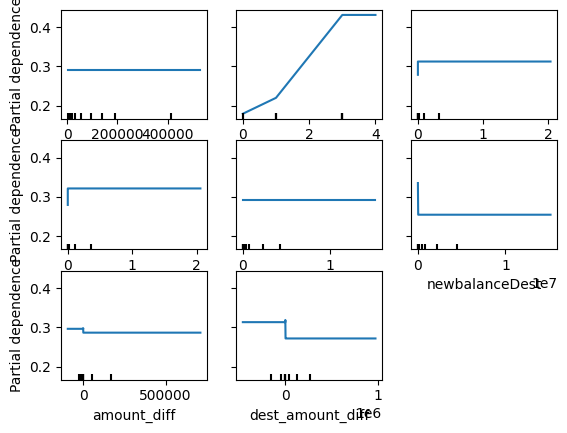

In [34]:
print("\nPartial Dependence Plots:")
partial_dependence_plots(random_forest, X_test)


Feature Importance Plot:


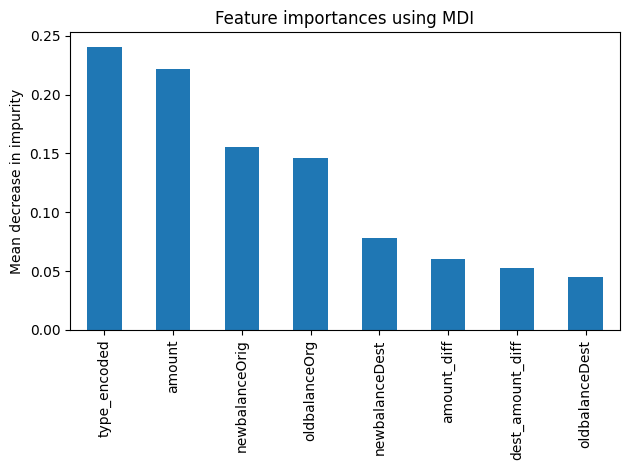

In [35]:
print("\nFeature Importance Plot:")
feature_importance_plot(random_forest, X_test)


Tree Interpreter Analysis:


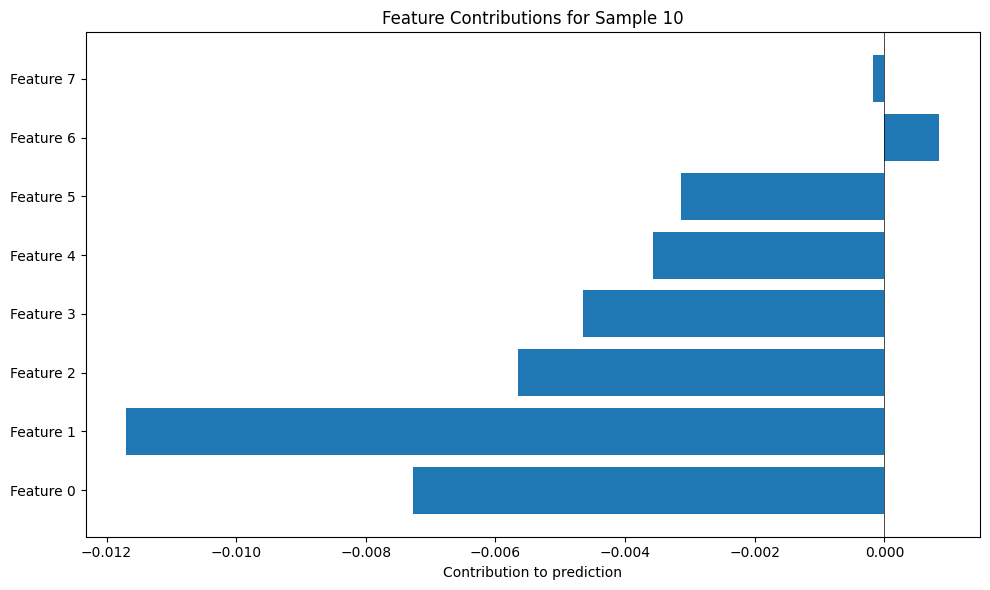

Sample 10:
Prediction: 0.0000
Bias (average model prediction): 0.5000
Top 5 contributing features:
  Feature 1: -0.0117
  Feature 0: -0.0073
  Feature 2: -0.0057
  Feature 3: -0.0047
  Feature 4: -0.0036




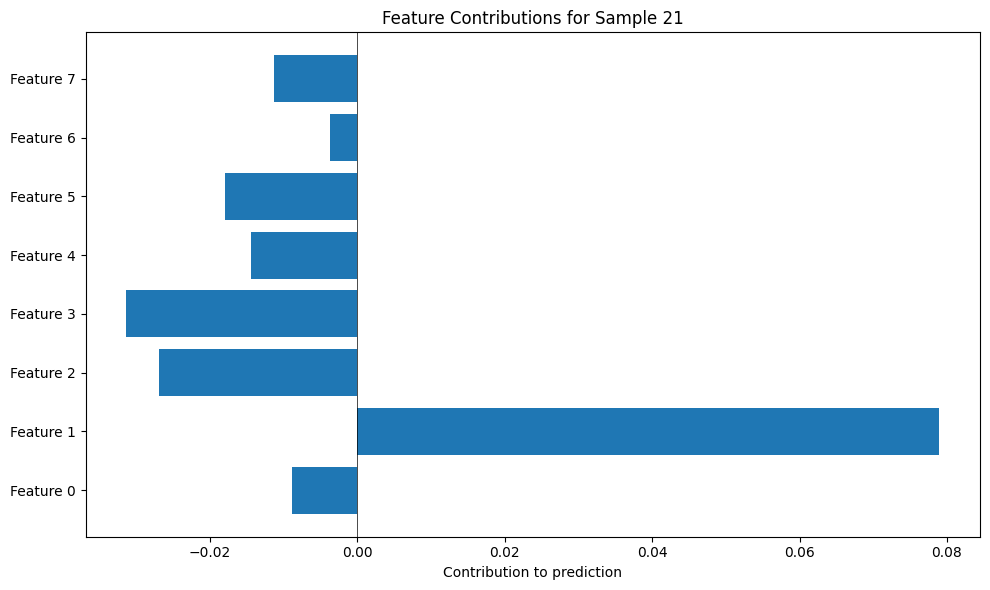

Sample 21:
Prediction: 0.0000
Bias (average model prediction): 0.5000
Top 5 contributing features:
  Feature 1: 0.0790
  Feature 3: -0.0313
  Feature 2: -0.0268
  Feature 5: -0.0179
  Feature 4: -0.0144




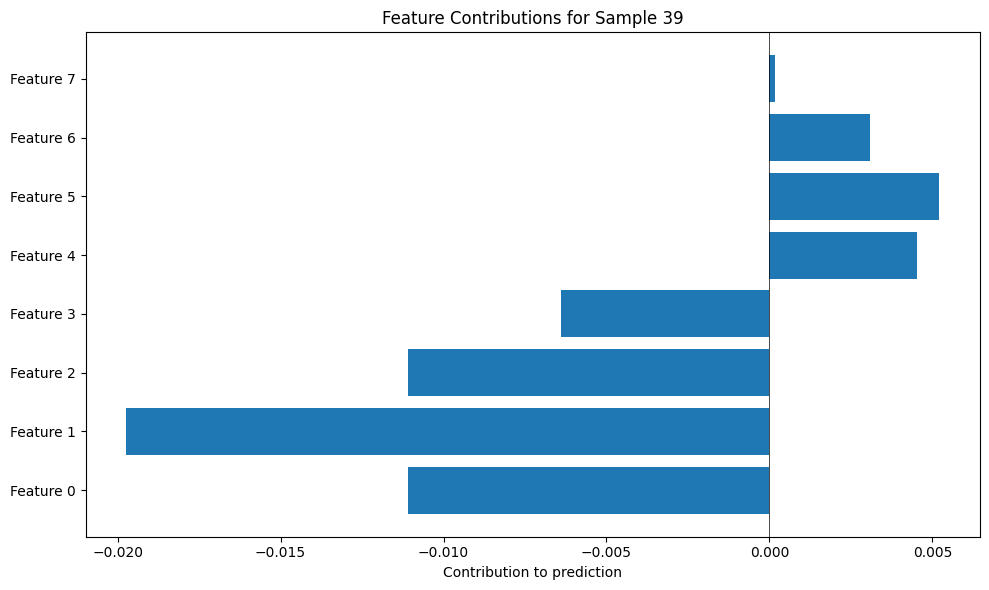

Sample 39:
Prediction: 0.0000
Bias (average model prediction): 0.5000
Top 5 contributing features:
  Feature 1: -0.0197
  Feature 0: -0.0111
  Feature 2: -0.0111
  Feature 3: -0.0064
  Feature 5: 0.0052




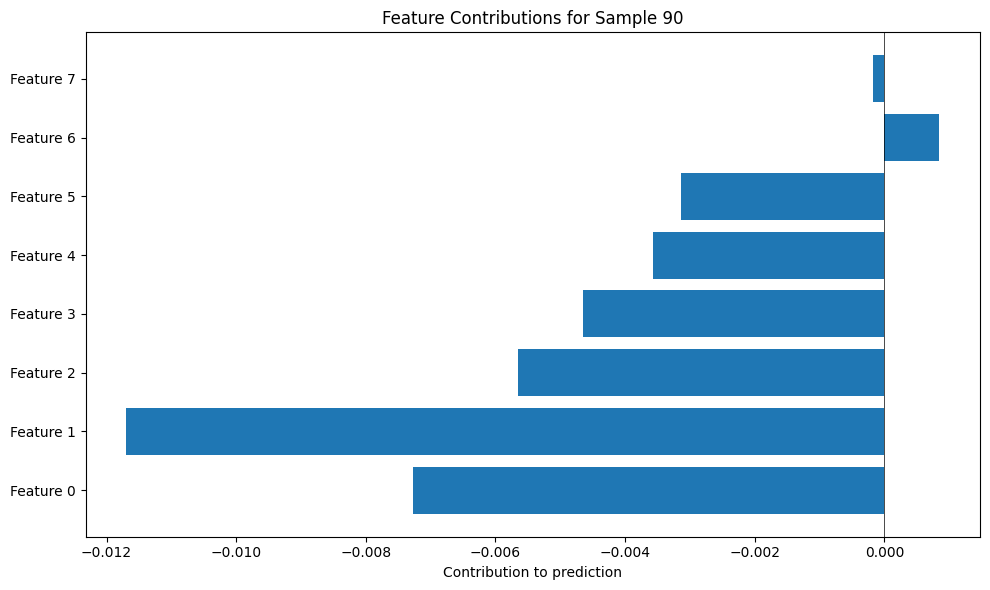

Sample 90:
Prediction: 0.0000
Bias (average model prediction): 0.5000
Top 5 contributing features:
  Feature 1: -0.0117
  Feature 0: -0.0073
  Feature 2: -0.0057
  Feature 3: -0.0047
  Feature 4: -0.0036




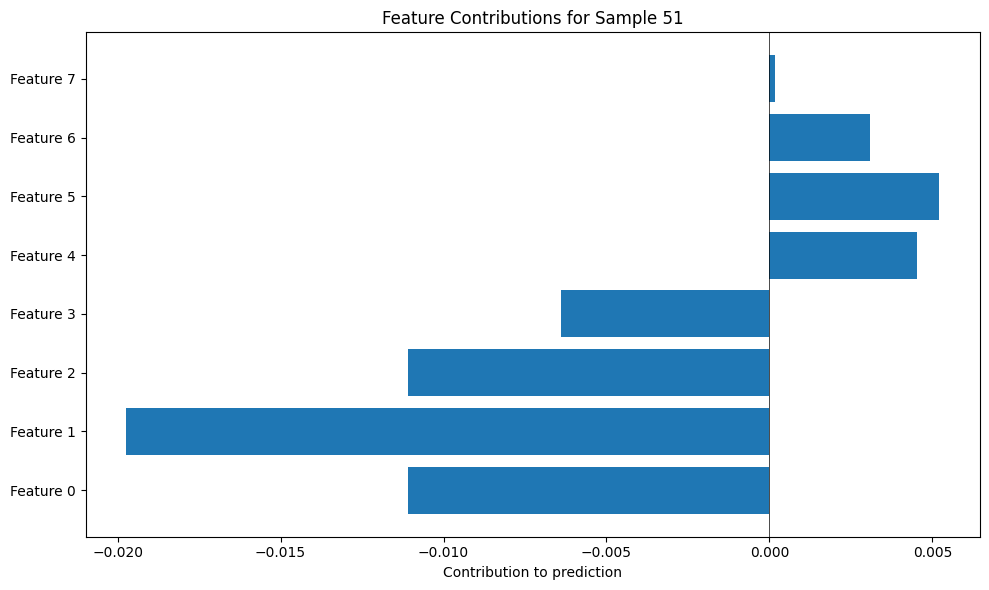

Sample 51:
Prediction: 0.0000
Bias (average model prediction): 0.5000
Top 5 contributing features:
  Feature 1: -0.0197
  Feature 0: -0.0111
  Feature 2: -0.0111
  Feature 3: -0.0064
  Feature 5: 0.0052




In [36]:
print("\nTree Interpreter Analysis:")
tree_interpreter_analysis(random_forest, X_test_scaled)